# FreeSurfer MRI reconstruction

This tutorial covers how to use FreeSurfer alongside MNE-Python, to handle the
structural MRI data that we use to build subject-specific anatomical models of
the scalp, inner/outer skull, and cortical surface.

In [2]:
# This notebook is based on MNE-Python tutorial:
# https://mne.tools/stable/auto_tutorials/forward/10_background_freesurfer.html

# Modified by Olaf Hauk, olaf.hauk@mrc-cbu.cam.ac.uk
# These notebooks complement the online lectures "Introduction to EEG/MEG analysis":
# https://www.youtube.com/playlist?list=PLp67eqWCj2f_DBsCMkIOBpBbLWGAUKtu5


# FreeSurfer MRI reconstruction

This tutorial covers how to use FreeSurfer alongside MNE-Python, to handle the
structural MRI data that we use to build subject-specific anatomical models of
the scalp, inner/outer skull, and cortical surface.

FreeSurfer is an open source analysis toolbox for MRI data, available from
https://surfer.nmr.mgh.harvard.edu/. FreeSurfer provides graphical interfaces
for visualizing MRI data, several anatomical parcellations useful for creating
region-of-interest (ROI) labels, template brains such as ``fsaverage``, and
several command-line tools for tasks like finding tissue boundaries or morphing
brains to align analogous anatomical regions across subjects.

These FreeSurfer capabilities are necessary for MNE-Python to compute the
:term:`forward model <forward>` and set up the corresponding `source space
<mne.SourceSpaces>` (a grid of dipoles located on the cortical surface or
within the brain volume).


## First steps

After downloading and installing FreeSurfer, there are a few steps to set up
the environment. First is to define an environment variable ``FREESURFER_HOME``
and then run the FreeSurfer setup script:

```console
$ export FREESURFER_HOME=/path/to/FreeSurfer
$ source $FREESURFER_HOME/SetUpFreeSurfer.sh
```
<div class="alert alert-info"><h4>Note</h4><p>The FreeSurfer home directory will vary depending on your operating
    system and choices you made during installation. See the `FreeSurfer
    installation guide`_ for more info.</p></div>


Another important step is to tell FreeSurfer where to put the anatomical
reconstructions of your research subjects. This is done with an environment
variable called ``SUBJECTS_DIR``, which will contain the individual subjects'
reconstructions in separate sub-folders.

```console
$ export SUBJECTS_DIR=/path/to/your/subjects_dir
```
Again see the `FreeSurfer installation guide`_ for more info.


## Anatomical reconstruction

The first processing stage is the creation of various surface reconstructions.
Usually a full FreeSurfer reconstruction is obtained by the following commands:

```console
$ my_subject=sample
$ my_NIfTI=/path/to/NIfTI.nii.gz
$ recon-all -i $my_NIfTI -s $my_subject -all
```
where ``i`` stands for "input" and ``s`` for "subject". Executing this will
create the folder :file:`$SUBJECTS_DIR/sample` and populate it
with several subfolders (``bem``, ``label``, ``mri``, etc). See also the
FreeSurfer wiki's `recommended reconstruction workflow`_ for more detailed
explanation.

<div class="alert alert-danger"><h4>Warning</h4><p>Anatomical reconstruction can take several hours, even on a fast computer.</p></div>

FreeSurfer performs a hemispheric separation so most resulting files have
separate left and right hemisphere versions, indicated by the prefix
``lh`` or ``rh``. This hemispheric separation is preserved by MNE-Python (e.g.,
`mne.SourceEstimate` objects store spatial locations (vertices) for the two
hemispheres separately; cf. `tut-source-estimate-class`).

Below we show an example of the results of a FreeSurfer reconstruction for the
left hemisphere of the `sample-dataset` dataset subject, including an
overlay of an anatomical parcellation (in this case, the parcellation from
:footcite:`DestrieuxEtAl2010`).


In [3]:
import numpy as np
import mne

sample_data_folder = mne.datasets.sample.data_path()
subjects_dir = sample_data_folder / "subjects"
Brain = mne.viz.get_brain_class()
brain = Brain(
    "sample", hemi="lh", surf="pial", subjects_dir=subjects_dir, size=(800, 600)
)
brain.add_annotation("aparc.a2009s", borders=False)

Using pyvistaqt 3d backend.
False


<OrthoSlicer3D: C:/Users/olaf/mne_data/MNE-sample-data/subjects/sample/mri/T1.mgz (256, 256, 256)>

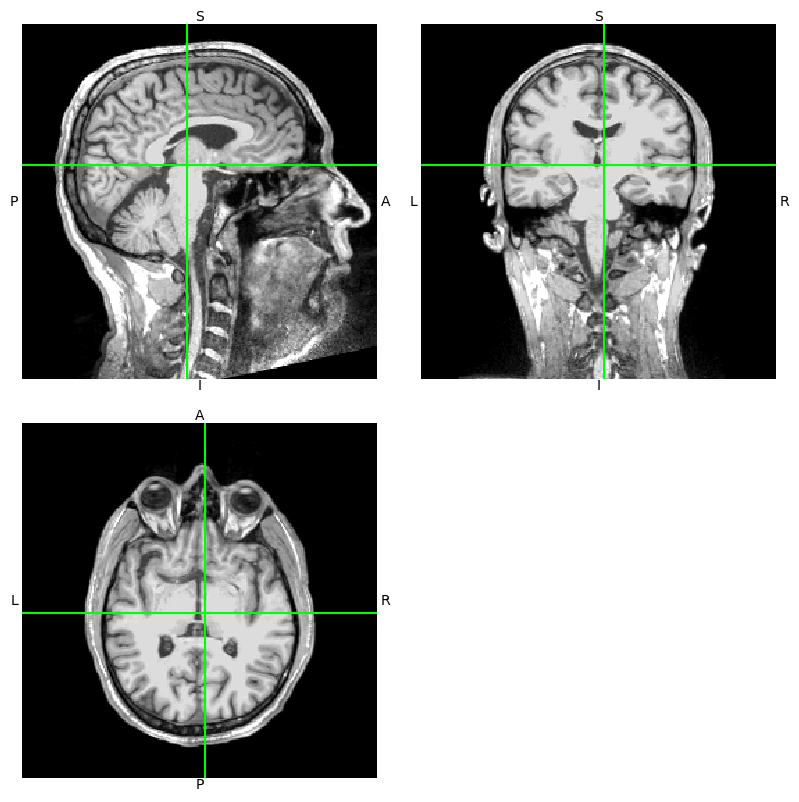

In [5]:
# we can also visualise the original MRI image
import nibabel
subject = "sample"
t1_fname = subjects_dir / subject / "mri" / "T1.mgz"
t1 = nibabel.load(t1_fname)
t1.orthoview()

### Cortical alignment (spherical)
A critical function provided by FreeSurfer is spherical surface alignment
of cortical surfaces, maximizing sulcal-gyral alignment. FreeSurfer first
expands the cortical surface to a sphere, then aligns it optimally with
fsaverage. Because the vertex ordering is preserved when expanding to a
sphere, a given vertex in the source (sample) mesh can be mapped easily
to the same location in the destination (fsaverage) mesh, and vice-versa.


In [6]:
view_kwargs = dict(elevation=90, azimuth=0)  # camera at +X with +Z up
renderer_kwargs = dict(bgcolor="w")
renderer = mne.viz.backends.renderer.create_3d_figure(
    size=(800, 400), scene=False, **renderer_kwargs
)
curvs = [
    (
        mne.surface.read_curvature(
            subjects_dir / subj / "surf" / "rh.curv", binary=False
        )
        > 0
    ).astype(float)
    for subj in ("sample", "fsaverage")
    for _ in range(2)
]
fnames = [
    subjects_dir / subj / "surf" / surf
    for subj in ("sample", "fsaverage")
    for surf in ("rh.white", "rh.sphere")
]
y_shifts = [-450, -150, 450, 150]
z_shifts = [-40, 0, -30, 0]
for name, y_shift, z_shift, curv in zip(fnames, y_shifts, z_shifts, curvs):
    this_rr, this_tri = mne.read_surface(name)
    this_rr += [0, y_shift, z_shift]
    renderer.mesh(
        *this_rr.T,
        triangles=this_tri,
        color=None,
        scalars=curv,
        colormap="copper_r",
        vmin=-0.2,
        vmax=1.2,
    )
zero = [0.0, 0.0, 0.0]
width = 50.0
y = np.sort(y_shifts)
y = (y[1:] + y[:-1]) / 2.0 - width / 2.0
renderer.quiver3d(zero, y, zero, zero, [1] * 3, zero, "k", width, "arrow")
view_kwargs["focalpoint"] = (0.0, 0.0, 0.0)
mne.viz.set_3d_view(figure=renderer.figure, distance=1050, **view_kwargs)
renderer.show()

False


### Surface decimation
These surfaces have a lot of vertices, and in general we only need to use
a subset of these vertices for creating source spaces. A uniform sampling can
easily be achieved by subsampling in the spherical space. To do this, we
use a recursively subdivided icosahedron or octahedron. For example, let's
load a standard oct-6 source space, and at the same zoom level as before
visualize how it subsampled (in red) the dense mesh:

In [7]:
src = mne.read_source_spaces(subjects_dir / "sample" / "bem" / "sample-oct-6-src.fif")
print(src)

cyan = "#66CCEE"
red = "#EE6677"
renderer = mne.viz.backends.renderer.create_3d_figure(
    size=(800, 800), scene=False, **renderer_kwargs
)
rr_sph, _ = mne.read_surface(fnames[1])
for tris, color in [(src[1]["tris"], cyan), (src[1]["use_tris"], red)]:
    # cull to the subset of tris with all positive X (toward camera)
    tris = tris[(rr_sph[tris, 0] > 0).all(axis=1)]
    renderer.mesh(
        *rr_sph.T,
        triangles=tris,
        color=color,
        representation="wireframe",
        line_width=3,
        render_lines_as_tubes=True,
    )
mne.viz.set_3d_view(figure=renderer.figure, distance=150, **view_kwargs)
renderer.show()

    Reading a source space...
    Computing patch statistics...
    Patch information added...
    Distance information added...
    [done]
    Reading a source space...
    Computing patch statistics...
    Patch information added...
    Distance information added...
    [done]
    2 source spaces read
<SourceSpaces: [<surface (lh), n_vertices=155407, n_used=4098>, <surface (rh), n_vertices=156866, n_used=4098>] MRI (surface RAS) coords, subject 'sample', ~27.5 MiB>
False


In [8]:
renderer = mne.viz.backends.renderer.create_3d_figure(
    size=(800, 400), scene=False, **renderer_kwargs
)
y_shifts = [-125, 125]
tris = [src[1]["tris"], src[1]["use_tris"]]
for y_shift, tris in zip(y_shifts, tris):
    this_rr = src[1]["rr"] * 1000.0 + [0, y_shift, -40]
    renderer.mesh(
        *this_rr.T,
        triangles=tris,
        color=None,
        scalars=curvs[0],
        colormap="copper_r",
        vmin=-0.2,
        vmax=1.2,
    )
renderer.quiver3d([0], [-width / 2.0], [0], [0], [1], [0], "k", width, "arrow")
mne.viz.set_3d_view(figure=renderer.figure, distance=450, **view_kwargs)
renderer.show()

False


## Average Brain (fsaverage) with MNE-Python

For source localization analysis to work properly, it is important that the
FreeSurfer reconstruction has completed beforehand. Furthermore, for many
MNE-Python functions related to inverse imaging (such as
`mne.setup_source_space`), ``SUBJECTS_DIR`` has to be defined globally (as an
environment variable or through a call to `mne.set_config`), or specified
separately in each function call by passing the keyword argument
``subjects_dir='/path/to/your/subjects_dir'``.

See `setting_up_source_space` to get an idea of how this works for one
particular function, and `tut-freesurfer-mne` for more details on how
MNE-Python and FreeSurfer are integrated.


## 'fsaverage'

During installation, FreeSurfer copies a subject called ``'fsaverage'`` to
``$FREESURFER_HOME/subjects/fsaverage``. ``fsaverage`` is a template brain
based on a combination of 40 MRI scans of real brains. The ``fsaverage``
subject folder contains all the files that a normal subject reconstruction
would yield. See https://surfer.nmr.mgh.harvard.edu/fswiki/FsAverage for an
overview, and https://surfer.nmr.mgh.harvard.edu/fswiki/Buckner40Notes for
details about the subjects used to create ``fsaverage``. A copy of
``fsaverage`` is also provided as part of the `sample-dataset` dataset
and is also distributed as a `standalone dataset <fsaverage>`.

One of the most common uses of ``fsaverage`` is as a destination space for
cortical morphing / `source estimate transformations <ch_morph>`. In
other words, it is common to morph each individual subject's estimated brain
activity onto the ``fsaverage`` brain, so that group-level statistical
comparisons can be made.


## References

.. footbibliography::

   https://surfer.nmr.mgh.harvard.edu/fswiki/DownloadAndInstall
   https://surfer.nmr.mgh.harvard.edu/fswiki/RecommendedReconstruction

